In [375]:
%matplotlib inline
import os
import pandas
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
import numpy
import math
import itertools 
from scipy.stats import ttest_ind
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats
from sklearn import preprocessing
import seaborn as sns

##### Представление данных

In [376]:
mir_ratio_column = "miR_Ratio"
mir_ratio_2_column = "2_miR Ratio"
hemscore_column = "Hem_Score"
gender_column = "Gender"
diabetes_column = "Diabetes"
age_column = "Age"

##### Обработка данных

In [377]:
class SignificantMicroRNAFinder(object):

    def __init__(
            self, path, mir_ratio_2_theshold=40000, 
            housekeeping_gene="Ct_hsa-miR-16-5p", 
            special_housekeeping_gene=None,
            special_miRNA=None,
            output_files_folder="results/temp",
            output_files_prefix="mir16_hk_",
    ):
        self.path = path
        self.mir_ratio_2_theshold = mir_ratio_2_theshold
        self.housekeeping_gene = housekeeping_gene
        self.special_housekeeping_gene = special_housekeeping_gene
        self.special_miRNA = special_miRNA
        
        self.output_files_folder = output_files_folder
        self.output_files_prefix = output_files_prefix
        if not os.path.exists(self.output_files_folder):
            os.makedirs(self.output_files_folder)
        self.output_prefix = os.path.join(self.output_files_folder, self.output_files_prefix)
        
        self.data = self.prepare_data()
        self.data = self.normalize_expression(self.data)

        
    def normalize_expression(self, df):
        self.norm_exp_cols = []
        exp_cols = [col for col in df.columns if "Ct_" in col]
        for col in exp_cols:
            df[f"{col}_normalized"] = df.apply(
                lambda x: 
                    2**x[col]/2**x[self.housekeeping_gene]
                    # 2**x[self.housekeeping_gene]/2**x[col]
                    if self.special_miRNA is None 
                        or col not in self.special_miRNA
                        or self.special_housekeeping_gene is None 
                        or pandas.isnull(x[self.special_housekeeping_gene])
                    else 
                        2**x[col]/2**x[self.special_housekeeping_gene], 
                        # 2**x[self.special_housekeeping_gene]/2**x[col], 
                axis=1
            )
            self.norm_exp_cols.append(f"{col}_normalized")

        return df

    def prepare_data(self):
        data = pandas.read_excel(self.path)
        data = data.replace(["Undetermined"], [None])
        data[mir_ratio_2_column] = data[mir_ratio_column].map(lambda x: 2**x)

        data.plot.scatter(x=hemscore_column, y=mir_ratio_2_column, title="Before filtering")

        data = self.filter_samples(data)
        data.plot.scatter(x=hemscore_column, y=mir_ratio_2_column, title="After filtering")

        return data


    def filter_samples(self, data):
        return data[data[mir_ratio_2_column] < self.mir_ratio_2_theshold]
    
    @staticmethod
    def highlight_cells(value, threshold=0.1, below=True):
        if below:
            if isinstance(value, float) and abs(value) <= threshold:
                return 'background-color: green'
        else:
            if isinstance(value, float) and abs(value) >= threshold:
                return 'background-color: green'
        
        return 'background-color: white'

    def regression_with_confounding_factors(
        self, group_column="Group",
        confounding_factors=[
            hemscore_column,
            #gender_column,
            diabetes_column,
            age_column,
            mir_ratio_column
        ]
    ):
        le = preprocessing.LabelEncoder()
        
        data = self.data.copy(deep=True)
        
        
        potential_microRNAs = set(self.norm_exp_cols) - set([self.housekeeping_gene + "_normalized"])
        if self.special_housekeeping_gene:
            potential_microRNAs -= set([self.special_housekeeping_gene + "_normalized"])
        
        # correlation between variables
        corr = data[list(potential_microRNAs) + confounding_factors].corr()
        sns.heatmap(corr)
        
        output_suffix = "_%s.xlsx" % "_".join(confounding_factors)

        # Create linear regression object
        lr_scores = pandas.DataFrame()
        regr = linear_model.LinearRegression()
        log2ratio = pandas.DataFrame()
        for group1, group2 in sorted(itertools.combinations(sorted(data[group_column].dropna().unique().tolist()), 2)):
            comparison_name = f"{group1}_vs_{group2}"
            res = {}
            l2r = {}
            for variable in list(potential_microRNAs):
                # Train the model using the training sets
                subdf = data[data[group_column].isin([group1, group2])].dropna(subset=confounding_factors + [variable])
                X = subdf[list(set([variable] + confounding_factors))]
                
                y = le.fit(subdf[group_column]).transform(subdf[group_column])

                X2 = sm.add_constant(X)
                est = sm.OLS(y, X2)
                est2 = est.fit()
                print("\n\n\nComparing groups", group1, group2, "for variable", variable, "\n\n\n")
                print(est2.summary())
                res[variable] = est2.pvalues[variable]
                l2r[variable] = math.log(
                    X.loc[subdf[subdf[group_column] == group1].index][variable].map(lambda x: 1/x).mean() / 
                    X.loc[subdf[subdf[group_column] == group2].index][variable].map(lambda x: 1/x).mean(),
                    2
                )
            log2ratio = log2ratio.append(pandas.DataFrame(l2r, index=[comparison_name]))
            lr_scores = lr_scores.append(pandas.DataFrame(res, index=[comparison_name]))
            multitests = multipletests(
                list(lr_scores.T[comparison_name].values), 
                alpha=0.05, 
                method="fdr_bh",
            )
            lr_scores.loc[comparison_name + "_mt"] = dict(zip(lr_scores.columns, multitests[1]))
            lr_scores = lr_scores.drop(index=comparison_name)
        
        lr_scores = lr_scores.sort_index()
        log2ratio = log2ratio.sort_index()
        
        lr_scores_styler = lr_scores.style.applymap(self.highlight_cells)
        lr_scores_styler.to_excel(f"{self.output_prefix}_group_col_{group_column}_pvalue_significance_{output_suffix}")
        
        log2ratio_styler = log2ratio.style.applymap(lambda x: self.highlight_cells(x, threshold=2, below=False))
        log2ratio_styler.to_excel(f"{self.output_prefix}_group_col_{group_column}_expression_log2Ratio_{output_suffix}")

        return lr_scores, log2ratio

##### Поиска значимо изменяющихся микроРНК в miR_CAD_Database




Comparing groups CONTR HT for variable Ct_hsa-miR-337-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     8.530
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           2.50e-05
Time:                        18:17:23   Log-Likelihood:                -25.385
No. Observations:                  55   AIC:                             60.77
Df Residuals:                      50   BIC:                             70.81
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     8.731
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           5.27e-06
Time:                        18:17:23   Log-Likelihood:                -22.928
No. Observations:                  56   AIC:                             57.86
Df Residuals:                      50   BIC:                             70.01
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     11.59
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           1.37e-07
Time:                        18:17:23   Log-Likelihood:                -21.017
No. Observations:                  59   AIC:                             54.03
Df Residuals:                      53   BIC:                             66.50
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 




Comparing groups CONTR S_CAD for variable Ct_hsa-miR-375_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     39.14
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           6.20e-17
Time:                        18:17:23   Log-Likelihood:                 2.0013
No. Observations:                  61   AIC:                             7.997
Df Residuals:                      55   BIC:                             20.66
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

strong multicollinearity or other numerical problems.



Comparing groups HT MI for variable Ct_hsa-miR-92a-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     5.556
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           0.000358
Time:                        18:17:23   Log-Likelihood:                -29.649
No. Observations:                  58   AIC:                             71.30
Df Residuals:                      52   BIC:                             83.66
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025




Comparing groups HT S_CAD for variable Ct_hsa-miR-92a-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     7.167
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           3.47e-05
Time:                        18:17:24   Log-Likelihood:                -27.509
No. Observations:                  59   AIC:                             67.02
Df Residuals:                      53   BIC:                             79.48
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups HT U_CAD for variable Ct_hsa-miR-17-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     9.353
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           2.12e-06
Time:                        18:17:24   Log-Likelihood:                -23.458
No. Observations:                  58   AIC:                             58.92
Df Residuals:                      52   BIC:                             71.28
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------




Comparing groups MI S_CAD for variable Ct_hsa-miR-126-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     4.352
Date:                Sun, 07 Jul 2019   Prob (F-statistic):            0.00208
Time:                        18:17:24   Log-Likelihood:                -34.097
No. Observations:                  61   AIC:                             80.19
Df Residuals:                      55   BIC:                             92.86
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups MI U_CAD for variable Ct_hsa-miR-145-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     3.165
Date:                Sun, 07 Jul 2019   Prob (F-statistic):             0.0141
Time:                        18:17:24   Log-Likelihood:                -35.837
No. Observations:                  60   AIC:                             83.67
Df Residuals:                      54   BIC:                             96.24
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups S_CAD U_CAD for variable Ct_hsa-miR-155-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.316
Date:                Sun, 07 Jul 2019   Prob (F-statistic):              0.271
Time:                        18:17:24   Log-Likelihood:                -40.819
No. Observations:                  61   AIC:                             93.64
Df Residuals:                      55   BIC:                             106.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

(                   Ct_hsa-miR-126-3p_normalized  Ct_hsa-miR-145-5p_normalized  \
 CONTR_vs_HT_mt                         0.858356                      0.858356   
 CONTR_vs_MI_mt                         0.323846                      0.376250   
 CONTR_vs_S_CAD_mt                      0.434237                      0.527806   
 CONTR_vs_U_CAD_mt                      0.714338                      0.004354   
 HT_vs_MI_mt                            0.520547                      0.456745   
 HT_vs_S_CAD_mt                         0.951307                      0.941781   
 HT_vs_U_CAD_mt                         0.340214                      0.123889   
 MI_vs_S_CAD_mt                         0.352093                      0.824975   
 MI_vs_U_CAD_mt                         0.695251                      0.162999   
 S_CAD_vs_U_CAD_mt                      0.571809                      0.571809   
 
                    Ct_hsa-miR-146a-5p_normalized  \
 CONTR_vs_HT_mt                          0.

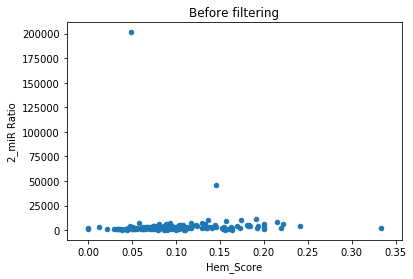

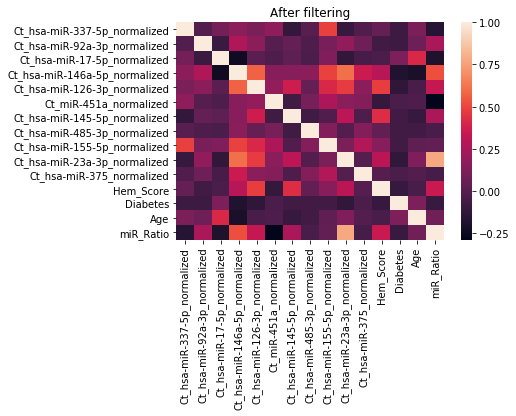

In [378]:
finder = SignificantMicroRNAFinder(
    "data/miR_CAD_Database_2019.xlsx", 
    special_housekeeping_gene="Ct_hsa-miR-16-5p_new",
    special_miRNA = [
        "Ct_hsa-miR-146a-5p",
        "Ct_hsa-miR-375", 
        "Ct_hsa-miR-23a-3p", 
        "Ct_miR-451a"
    ],
    output_files_folder="results/miR_CAD_Database_2019"
)
finder.regression_with_confounding_factors()

##### Поиск значимо изменяющихся микроРНК в AF_Database




Comparing groups AF_CAD AF_HT for variable Ct_miR-451a_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     2.702
Date:                Sun, 07 Jul 2019   Prob (F-statistic):             0.0325
Time:                        18:17:25   Log-Likelihood:                -28.575
No. Observations:                  50   AIC:                             69.15
Df Residuals:                      44   BIC:                             80.62
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

strong multicollinearity or other numerical problems.



Comparing groups AF_CAD CONTR for variable Ct_hsa-miR-29b-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     50.23
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           4.38e-17
Time:                        18:17:26   Log-Likelihood:                 12.312
No. Observations:                  50   AIC:                            -12.62
Df Residuals:                      44   BIC:                            -1.152
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|     

Comparing groups AF_CAD CONTR_CAD for variable Ct_hsa-miR-29b-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.8482
Date:                Sun, 07 Jul 2019   Prob (F-statistic):              0.525
Time:                        18:17:26   Log-Likelihood:                -26.681
No. Observations:                  40   AIC:                             65.36
Df Residuals:                      34   BIC:                             75.49
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------




Comparing groups AF_CAD HT for variable Ct_hsa-miR-375_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     13.31
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           8.66e-08
Time:                        18:17:26   Log-Likelihood:                -11.374
No. Observations:                  48   AIC:                             34.75
Df Residuals:                      42   BIC:                             45.98
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     19.75
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           3.89e-11
Time:                        18:17:26   Log-Likelihood:                -12.358
No. Observations:                  60   AIC:                             36.72
Df Residuals:                      54   BIC:                             49.28
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             




Comparing groups AF_HT CONTR_CAD for variable Ct_hsa-miR-23a-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1.843
Date:                Sun, 07 Jul 2019   Prob (F-statistic):              0.124
Time:                        18:17:26   Log-Likelihood:                -30.515
No. Observations:                  50   AIC:                             73.03
Df Residuals:                      44   BIC:                             84.50
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     3.813
Date:                Sun, 07 Jul 2019   Prob (F-statistic):            0.00512
Time:                        18:17:27   Log-Likelihood:                -33.003
No. Observations:                  58   AIC:                             78.01
Df Residuals:                      52   BIC:                             90.37
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           




Comparing groups CONTR CONTR_CAD for variable Ct_hsa-miR-19a-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     33.15
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           7.22e-14
Time:                        18:17:27   Log-Likelihood:                 3.7737
No. Observations:                  50   AIC:                             4.453
Df Residuals:                      44   BIC:                             15.92
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------




Comparing groups CONTR_CAD HT for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     9.921
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           2.57e-06
Time:                        18:17:27   Log-Likelihood:                -15.446
No. Observations:                  48   AIC:                             42.89
Df Residuals:                      42   BIC:                             54.12
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

(                        Ct_hsa-miR-146a-5p_normalized  \
 AF_CAD_vs_AF_HT_mt                           0.733088   
 AF_CAD_vs_CONTR_CAD_mt                       0.997388   
 AF_CAD_vs_CONTR_mt                           0.011733   
 AF_CAD_vs_HT_mt                              0.336580   
 AF_HT_vs_CONTR_CAD_mt                        0.991322   
 AF_HT_vs_CONTR_mt                            0.055374   
 AF_HT_vs_HT_mt                               0.565754   
 CONTR_CAD_vs_HT_mt                           0.790213   
 CONTR_vs_CONTR_CAD_mt                        0.324768   
 CONTR_vs_HT_mt                               0.560057   
 
                         Ct_hsa-miR-150-5p_normalized  \
 AF_CAD_vs_AF_HT_mt                          0.861585   
 AF_CAD_vs_CONTR_CAD_mt                      0.870168   
 AF_CAD_vs_CONTR_mt                          0.252242   
 AF_CAD_vs_HT_mt                             0.039498   
 AF_HT_vs_CONTR_CAD_mt                       0.524860   
 AF_HT_vs_CONTR_mt

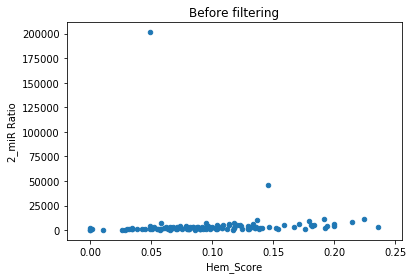

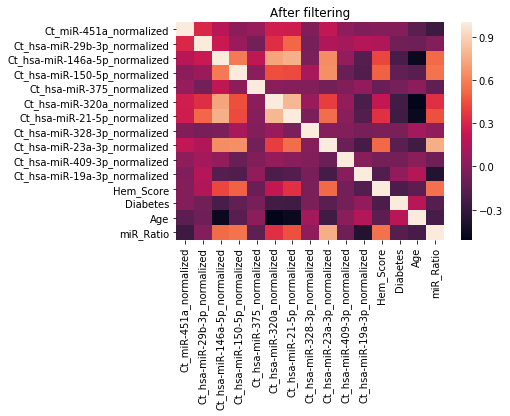

In [379]:
finder_af = SignificantMicroRNAFinder(
    "data/miR_AF_Database_2019.xlsx", 
    output_files_folder="results/miR_AF_Database_2019"
)
finder_af.regression_with_confounding_factors()

##### Поиска значимо изменяющихся микроРНК в зависимости от различных рисковых коэффициентов и шкал

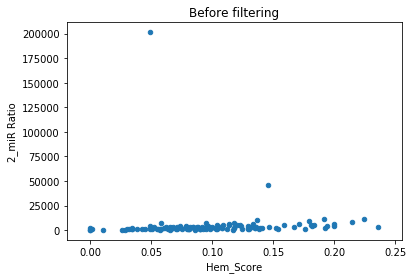

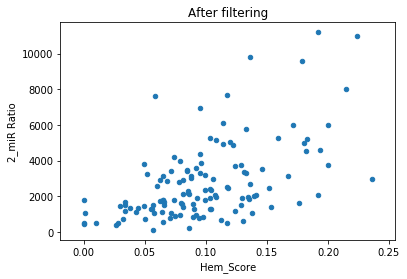

In [380]:
finder = SignificantMicroRNAFinder(
    "data/miR_AF_Database_2019_scales.xlsx", 
    output_files_folder="results/miR_AF_Database_2019_scales"
)




Comparing groups AF_CAD AF_HT for variable Ct_miR-451a_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     2.702
Date:                Sun, 07 Jul 2019   Prob (F-statistic):             0.0325
Time:                        18:17:29   Log-Likelihood:                -28.575
No. Observations:                  50   AIC:                             69.15
Df Residuals:                      44   BIC:                             80.62
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------




Comparing groups AF_CAD CONTR for variable Ct_hsa-miR-146a-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     60.19
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           1.47e-18
Time:                        18:17:29   Log-Likelihood:                 16.212
No. Observations:                  50   AIC:                            -20.42
Df Residuals:                      44   BIC:                            -8.951
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------




Comparing groups AF_CAD CONTR_CAD for variable Ct_hsa-miR-375_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.303
Date:                Sun, 07 Jul 2019   Prob (F-statistic):              0.286
Time:                        18:17:29   Log-Likelihood:                -25.526
No. Observations:                  40   AIC:                             63.05
Df Residuals:                      34   BIC:                             73.18
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------




Comparing groups AF_CAD HT for variable Ct_hsa-miR-328-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     14.55
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           2.81e-08
Time:                        18:17:29   Log-Likelihood:                -10.036
No. Observations:                  48   AIC:                             32.07
Df Residuals:                      42   BIC:                             43.30
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------




Comparing groups AF_HT CONTR for variable Ct_hsa-miR-409-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     18.23
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           1.48e-10
Time:                        18:17:30   Log-Likelihood:                -13.888
No. Observations:                  60   AIC:                             39.78
Df Residuals:                      54   BIC:                             52.34
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

strong multicollinearity or other numerical problems.



Comparing groups AF_HT CONTR_CAD for variable Ct_hsa-miR-19a-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     2.872
Date:                Sun, 07 Jul 2019   Prob (F-statistic):             0.0250
Time:                        18:17:30   Log-Likelihood:                -28.208
No. Observations:                  50   AIC:                             68.42
Df Residuals:                      44   BIC:                             79.89
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|  




Comparing groups CONTR CONTR_CAD for variable Ct_miR-451a_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     33.24
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           6.90e-14
Time:                        18:17:30   Log-Likelihood:                 3.8269
No. Observations:                  50   AIC:                             4.346
Df Residuals:                      44   BIC:                             15.82
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------




Comparing groups CONTR HT for variable Ct_hsa-miR-29b-3p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     7.144
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           0.000112
Time:                        18:17:30   Log-Likelihood:                -29.556
No. Observations:                  58   AIC:                             69.11
Df Residuals:                      53   BIC:                             79.41
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------




Comparing groups CONTR_CAD HT for variable Ct_hsa-miR-150-5p_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     9.901
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           2.63e-06
Time:                        18:17:30   Log-Likelihood:                -15.472
No. Observations:                  48   AIC:                             42.94
Df Residuals:                      42   BIC:                             54.17
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------




Comparing groups 0 1 for variable Ct_miR-451a_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     20.21
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           1.20e-14
Time:                        18:17:31   Log-Likelihood:                -34.506
No. Observations:                 128   AIC:                             81.01
Df Residuals:                     122   BIC:                             98.12
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------




Comparing groups 0 1 for variable Ct_miR-451a_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     44.79
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           4.78e-26
Time:                        18:17:31   Log-Likelihood:                -22.583
No. Observations:                 128   AIC:                             57.17
Df Residuals:                     122   BIC:                             74.28
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------




Comparing groups 0 1 for variable Ct_miR-451a_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.787
Date:                Sun, 07 Jul 2019   Prob (F-statistic):             0.0203
Time:                        18:17:31   Log-Likelihood:                -52.168
No. Observations:                 128   AIC:                             116.3
Df Residuals:                     122   BIC:                             133.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------




Comparing groups 0 1 for variable Ct_miR-451a_normalized 



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     57.46
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           1.88e-30
Time:                        18:17:32   Log-Likelihood:                -13.852
No. Observations:                 128   AIC:                             39.70
Df Residuals:                     122   BIC:                             56.82
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

(           Ct_hsa-miR-146a-5p_normalized  Ct_hsa-miR-150-5p_normalized  \
 0_vs_1_mt                       0.231668                      0.868209   
 
            Ct_hsa-miR-19a-3p_normalized  Ct_hsa-miR-21-5p_normalized  \
 0_vs_1_mt                      0.868209                     0.507857   
 
            Ct_hsa-miR-23a-3p_normalized  Ct_hsa-miR-29b-3p_normalized  \
 0_vs_1_mt                      0.612562                      0.514199   
 
            Ct_hsa-miR-320a_normalized  Ct_hsa-miR-328-3p_normalized  \
 0_vs_1_mt                     0.32157                      0.868209   
 
            Ct_hsa-miR-375_normalized  Ct_hsa-miR-409-3p_normalized  \
 0_vs_1_mt                   0.514199                      0.868209   
 
            Ct_miR-451a_normalized  
 0_vs_1_mt                0.514199  ,
         Ct_hsa-miR-146a-5p_normalized  Ct_hsa-miR-150-5p_normalized  \
 0_vs_1                      -1.978596                     -1.836131   
 
         Ct_hsa-miR-19a-3p_normalized  

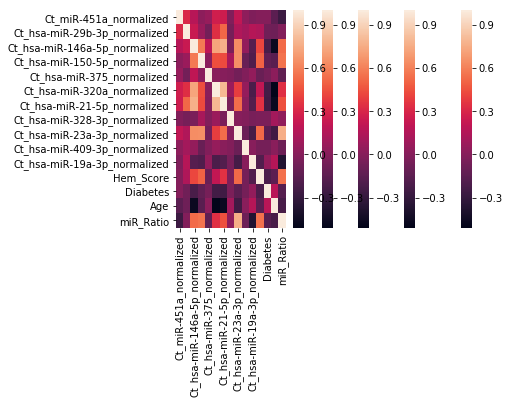

In [381]:
finder.regression_with_confounding_factors()
finder.regression_with_confounding_factors(group_column="CHA2DS2VASc_1")
finder.regression_with_confounding_factors(group_column="CHA2DS2VASc_2")
finder.regression_with_confounding_factors(group_column="SCORE_5")
finder.regression_with_confounding_factors(group_column="ACC_AHA_7,5")